# Ejercicio sobre RNNs

Carlos Checa Moreno

i02chmoc@uco.es

Para empezar, descargo y preparo los datos

In [1]:
pip install kagglehub[pandas-datasets]

In [2]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
# **Change this to the actual path of the file in the dataset:**
file_path = "catfish.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "yekahaaagayeham/time-series-toy-data-set",
  file_path,
  # Provide any additional arguments like
  # sql_query or pandas_kwargs. See the
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

print("First 5 records:", df.head())

<ipython-input-2-fe3f539e9d23>:11: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


100%|██████████| 5.46k/5.46k [00:00<00:00, 6.99MB/s]

First 5 records:         Date  Total
0  1986-1-01   9034
1  1986-2-01   9596
2  1986-3-01  10558
3  1986-4-01   9002
4  1986-5-01   9239


## Utilizar Keras para construir y entrenar redes LSTM con series temporales

In [3]:
import tensorflow as tf
from tensorflow import keras

import numpy
import matplotlib.pyplot as plt
import pandas as pd
import math

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, InputLayer

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

            Total
Date             
1986-01-01   9034
1986-02-01   9596
1986-03-01  10558
1986-04-01   9002
1986-05-01   9239


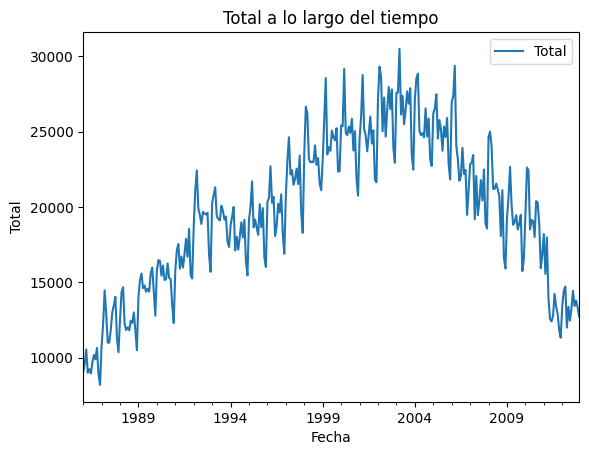

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Convertir la columna 'Date' a formato datetime
df['Date'] = pd.to_datetime(df['Date'])

# Establecer 'Date' como índice
df.set_index('Date', inplace=True)

# Mostrar los primeros datos
print(df.head())

# Usar matplotlib para mostrar la serie
df.plot()
plt.title("Total a lo largo del tiempo")
plt.ylabel("Total")
plt.xlabel("Fecha")
plt.show()

# Fijar la semilla para reproducibilidad
np.random.seed(7)


Escalo los datos ya que las redes LSTM son sensibles a la escala de los datos de entrada.

In [5]:
from sklearn.preprocessing import MinMaxScaler
total = df['Total']
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(total.values.reshape(-1, 1))
print(dataset[:5])

[[0.03759702]
 [0.06281125]
 [0.10597156]
 [0.03616134]
 [0.04679438]]


In [6]:
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print(f'Tamaño del conjunto de entrenamiento: {len(train)}')
print(f'Tamaño del conjunto de prueba: {len(test)}')

Tamaño del conjunto de entrenamiento: 217
Tamaño del conjunto de prueba: 107


A continuación, se prepara la serie temporal para entrenar la red LSTM. Luego se ajusta el formato para que la LSTM pueda leerlos correctamente.

Se construye una red simple con una capa LSTM y una de salida, configurada para mantener su memoria entre lotes (stateful=True). Finalmente, se entrena la red durante 100 épocas reiniciando su estado en cada una para controlar mejor el aprendizaje.

In [7]:
# Convertir un array en un conjunto de datos
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# Preparar el conjunto de train
look_back = 1
trainX, trainY = create_dataset(train, look_back)

# Preparar el conjunto de test
testX, testY = create_dataset(test, look_back)

# Reshape para tener [samples, time steps, features]
trainX = trainX.reshape(trainX.shape[0], 1, trainX.shape[1])
testX = testX.reshape(testX.shape[0], 1, testX.shape[1])

# Tamaño de batch
batch_size = 1

# Crear un modelo secuencial
model = Sequential()

# Crear una capa LSTM
model.add(InputLayer(batch_input_shape=(batch_size, look_back, 1)))  # 1 es el número de características por timestep
model.add(LSTM(10, stateful=True))

# Crear una capa densa
model.add(Dense(1))

# Compilar el modelo
model.compile(loss='mean_squared_error', optimizer='adam')

# Entrenar el modelo
model.fit(trainX, trainY, epochs=50, batch_size=batch_size, verbose=2)

# Hacer predicciones sobre el conjunto de test
predictions = model.predict(testX, batch_size=batch_size)

# Mostrar las primeras predicciones
print(predictions[:5])


Epoch 1/50
215/215 - 3s - 15ms/step - loss: 0.0899
Epoch 2/50
215/215 - 1s - 5ms/step - loss: 0.0409
Epoch 3/50
215/215 - 1s - 6ms/step - loss: 0.0330
Epoch 4/50
215/215 - 1s - 5ms/step - loss: 0.0249
Epoch 5/50
215/215 - 1s - 5ms/step - loss: 0.0170
Epoch 6/50
215/215 - 1s - 4ms/step - loss: 0.0099
Epoch 7/50
215/215 - 1s - 4ms/step - loss: 0.0082
Epoch 8/50
215/215 - 1s - 3ms/step - loss: 0.0080
Epoch 9/50
215/215 - 1s - 3ms/step - loss: 0.0074
Epoch 10/50
215/215 - 1s - 3ms/step - loss: 0.0073
Epoch 11/50
215/215 - 1s - 4ms/step - loss: 0.0070
Epoch 12/50
215/215 - 1s - 6ms/step - loss: 0.0071
Epoch 13/50
215/215 - 1s - 5ms/step - loss: 0.0071
Epoch 14/50
215/215 - 1s - 3ms/step - loss: 0.0069
Epoch 15/50
215/215 - 1s - 3ms/step - loss: 0.0069
Epoch 16/50
215/215 - 1s - 3ms/step - loss: 0.0072
Epoch 17/50
215/215 - 1s - 3ms/step - loss: 0.0075
Epoch 18/50
215/215 - 0s - 2ms/step - loss: 0.0072
Epoch 19/50
215/215 - 0s - 2ms/step - loss: 0.0075
Epoch 20/50
215/215 - 0s - 2ms/step - l

Una vez entrenado el modelo, evaluamos su rendimiento en los datos de entrenamiento y prueba. Para que el error tenga sentido, primero deshacemos la normalización de las predicciones y así comparamos en las mismas unidades que los datos reales.

In [9]:
import numpy as np
import math
from sklearn.metrics import mean_squared_error

# Realizar las predicciones sobre el conjunto de entrenamiento y prueba
trainPredict = model.predict(trainX, batch_size=batch_size)
testPredict = model.predict(testX, batch_size=batch_size)

# Deshacer la normalización
trainPredict = scaler.inverse_transform(trainPredict)
trainYOriginal = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testYOriginal = scaler.inverse_transform([testY])

# Calcular los errores
trainScore = math.sqrt(mean_squared_error(trainYOriginal[0], trainPredict[:, 0]))
print('Train Score: %.2f RMSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(testYOriginal[0], testPredict[:, 0]))
print('Test Score: %.2f RMSE' % (testScore))


215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Train Score: 2300.59 RMSE
Test Score: 2407.35 RMSE


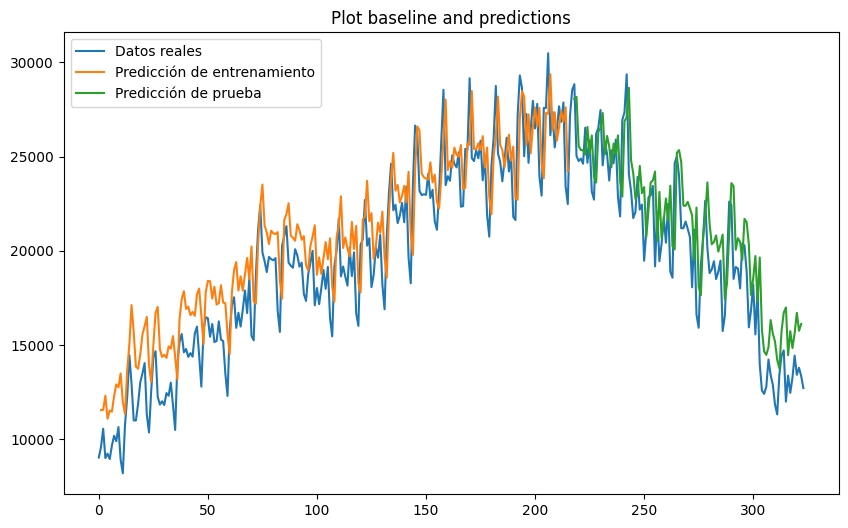

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Hacer un shift de las predicciones de entrenamiento para el plot
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# Hacer un shift de las predicciones de test para el plot
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# Representar las predicciones
plt.figure(figsize=(10, 6))
plt.title("Plot baseline and predictions")
plt.plot(scaler.inverse_transform(dataset), label="Datos reales")
plt.plot(trainPredictPlot, label="Predicción de entrenamiento")
plt.plot(testPredictPlot, label="Predicción de prueba")
plt.legend(loc="best")
plt.show()


## Referencias

Este material se ha basado en la entrada ["Time Series Prediction with LSTM Recurrent Neural Networks in Python with Keras"](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/) de Machine Learning Mastery. Es muy recomendable consultar la entrada completa.